<a href="https://colab.research.google.com/github/mbalbi/ciencia_de_datos/blob/main/tps/1c2024/Practica_Datos_Espaciales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica: Introducción a Sistemas de Información Geográfica (SIG)

## Importamos Librerias

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Leer y explorar archivos vectoriales

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Radios_CantParadas.gpkg to Radios_CantParadas.gpkg


Cargamos la capa vectorial usando la libreria **Geopandas**:

¡Esta capa es la que generamos con QGIS en la etapa anterior!

In [ ]:
Centroide_Radios = gpd.read_file('Centroide_Radios_5348_Datos1.gpkg')
print(type(Centroide_Radios))

<class 'geopandas.geodataframe.GeoDataFrame'>


In [ ]:
Centroide_Radios.head(2)

,link,Area_ha,NOMBRE,CUENCA,fna,gna,Manchas_X_TR,Dist_CentrosSalud,geometry
0,020060903,1.904,None,None,Comuna 6,Comuna,NaN,161.55495,POINT (6368170.951 6168814.256)
1,020130809,1.295,None,None,Comuna 13,Comuna,NaN,967.47095,POINT (6366028.960 6175657.527)


Cargamos y unimos la cantidad de paradas a 500 mts de los centroides de los radios censales

In [ ]:
CantParadas = gpd.read_file('Radios_CantParadas.gpkg')
CantParadas = CantParadas[['link','CantParadas']]
Centroide_Radios = pd.merge(Centroide_Radios,CantParadas,on='link')

Podemos aprovechar todas las **funcionalidades de pandas** para trabajar con archivos vectoriales.

In [ ]:
Centroide_Radios.head(2)

,link,Area_ha,NOMBRE,CUENCA,fna,gna,Manchas_X_TR,Dist_CentrosSalud,geometry,CantParadas
0,020060903,1.904,None,None,Comuna 6,Comuna,NaN,161.55495,POINT (6368170.951 6168814.256),64.0
1,020130809,1.295,None,None,Comuna 13,Comuna,NaN,967.47095,POINT (6366028.960 6175657.527),30.0


In [ ]:
Centroide_Radios.columns

Index(['link', 'Area_ha', 'NOMBRE', 'CUENCA', 'fna', 'gna', 'Manchas_X_TR',
       'Dist_CentrosSalud', 'geometry', 'CantParadas'],
      dtype='object')

Este punto está escrito en **formato WKT**, que es una forma estándar de representar objetos geométricos como puntos, líneas o polígonos.

El formato **POINT (x y)** indica un punto en un sistema de coordenadas con la posición en los ejes X y Y.

In [ ]:
print(Centroide_Radios.geometry[0])

POINT (6368170.951394833 6168814.255850054)


Consultamos el **Sistema de referencia de coordenadas (SRC ó CRS)** de la capa.

In [ ]:
Centroide_Radios.crs

<Projected CRS: EPSG:5348>
Name: POSGAR 2007 / Argentina 6
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Argentina - between 58°30'W and 55°30'W, onshore.
- bounds: (-58.5, -38.59, -55.49, -24.84)
Coordinate Operation:
- name: Argentina zone 6
- method: Transverse Mercator
Datum: Posiciones Geodesicas Argentinas 2007
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Creemos un mapa para ver la Ubicación de los puntos que generamos.

Para ayudar en la visualización vamos a agregar un Mapa Base con la libreria ***contextily***

In [ ]:
# Mapa Base
try:
  import contextily as cx
except:
  !pip install contextily
  import contextily as cx

Necesitamos reproyectar la capa al mismos SRC de la capa base, el cuale es **WGS 84 / Pseudo-Mercator**.

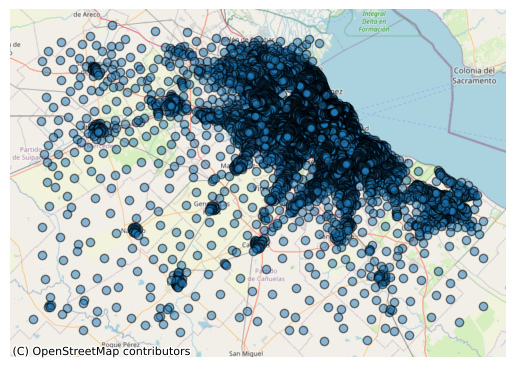

In [ ]:
# Reproyectamos la capa al SRC: WGS 84 / Pseudo-Mercator
Centroide_Radios_3857 = Centroide_Radios.to_crs(epsg=3857)
# Capa Vectorial
ax = Centroide_Radios_3857.plot( alpha=0.5, edgecolor="k")
# Capa Base
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)
# Quitamos los ejes
ax.set_axis_off()
plt.show()
plt.close()

## Filtramos los Redios Censales

Vamos a trabajar únicamente con algunos radios censales.

### **Filtro 1**:
En este caso, nos centraremos en aquellos que se encuentran en la Cuenca Baja y Cuenca Media del Matanza-Riachuelo.

In [ ]:
len(Centroide_Radios)  # Total de radios censales

15089

In [ ]:
Centroide_Radios.CUENCA.unique()  # Cuencas disponibles en los datos

array([None, 'BAJA', 'ALTA', 'MEDIA'], dtype=object)

In [ ]:
# Filtrar por cuencas 'BAJA' y 'MEDIA'
Centroide_Radios_filt = Centroide_Radios[Centroide_Radios['CUENCA'].isin(['BAJA', 'MEDIA'])].copy()
len(Centroide_Radios_filt)  # Cantidad de radios censales en las cuencas seleccionadas

3424

### **Filtro 2**:
Filtramos los radios censales con áreas menores a 20 hectáreas (ha).
El **objetivo** es concentrarnos en zonas más compactas y urbanas, donde encontramos una mayor densidad poblacional y variedad de infraestructura. Estas áreas son de mayor interés para proyectos de planificación urbana, infraestructura, o análisis de riesgo ambiental. Evitamos incluir áreas rurales o poco desarrolladas que podrían distorsionar los resultados.

Además, al trabajar con el centroide del radio censal, buscamos que exista una distancia mínima entre el centro y los límites del radio. Filtrar los radios censales grandes nos permite asegurarnos de que el centroide esté más representativo de la ubicación general del radio. Esto es crucial cuando evaluamos fenómenos como la accesibilidad a servicios o la proximidad a infraestructuras clave, ya que radios censales demasiado grandes pueden generar distorsiones en los resultados al estar más dispersos.


In [ ]:
# Exploramos las áreas de los distintos Radios Censales
Centroide_Radios_filt.Area_ha.describe()

,Area_ha
count,3424.000000
mean,35.487396
std,224.993748
min,0.336000
25%,6.654000
50%,10.779500
75%,16.954500
max,6431.725000


<Axes: xlabel='Area_ha', ylabel='Count'>

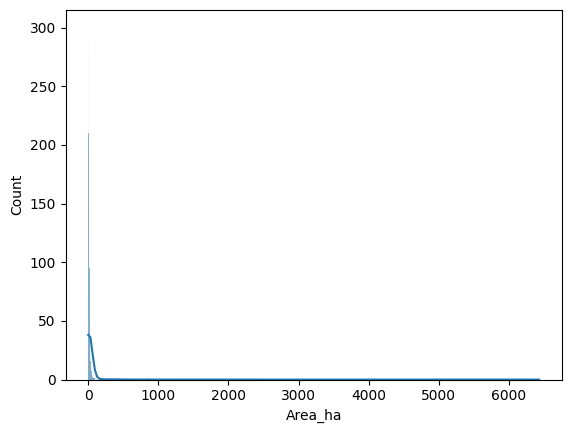

In [ ]:
sns.histplot(data=Centroide_Radios_filt, x="Area_ha", kde=True)

(0.0, 60.0)

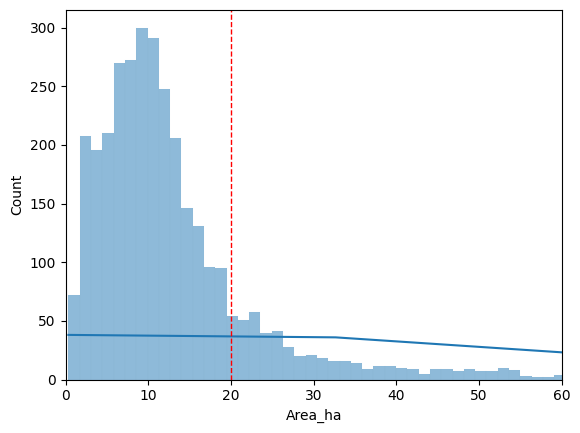

In [ ]:
# Zoom a la zona donde estan la mayoria de los datos
sns.histplot(data=Centroide_Radios_filt, x="Area_ha", kde=True)
plt.axvline(20,color = "red", linewidth = 1,
            linestyle = "dashed") # Corte adoptado
plt.xlim(0,60)

In [ ]:
Centroide_Radios_filt = Centroide_Radios_filt[Centroide_Radios_filt['Area_ha'] <= 20]
len(Centroide_Radios_filt)

2763

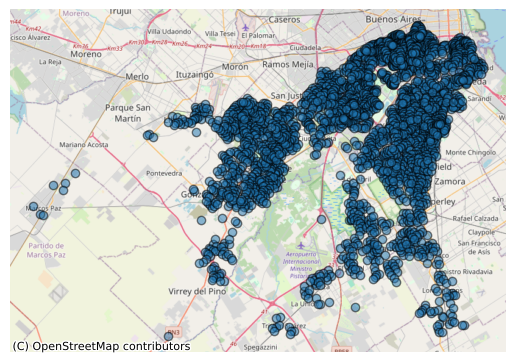

In [ ]:
Centroide_Radios_filt_3857 = Centroide_Radios_filt.to_crs(epsg=3857)# Reproyectamos la capa al SRC: WGS 84 / Pseudo-Mercator
ax = Centroide_Radios_filt_3857.plot( alpha=0.5, edgecolor="k")     # Capa Vectorial
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)        # Capa Base
ax.set_axis_off()                                                   # Quitamos los ejes
plt.show()
plt.close()

# Análisis Exploratorio de Datos

In [ ]:
Centroide_Radios_filt.columns

Index(['link', 'Area_ha', 'NOMBRE', 'CUENCA', 'fna', 'gna', 'Manchas_X_TR',
       'Dist_CentrosSalud', 'geometry', 'CantParadas'],
      dtype='object')

## Agregamos los datos del Censo 2010

Vamos a agregar los datos del Censo a nuestra capa de radios censales. Como mencionamos anteriormente, la columna ***link*** en nuestras capas nos permite unir la información de los radios censales entre distintas capas.

In [ ]:
# Montar Google Drive para acceder a los archivos
from google.colab import drive
drive.mount('/content/drive')
root_path = '/content/drive/MyDrive/ICDIC/GIS/Datos/'  # Esta es la ubicacion de los archivos en mi Drive.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Censo 2010 - Datos Basicos

In [ ]:
DatosBasicos = gpd.read_file(root_path+'Censo2010/DatosBasicos_4326.gpkg')
DatosBasicos = DatosBasicos.rename(columns={'viv_part_h':'viv_part_hab'})         # Renombramos la columna
del DatosBasicos['geometry']    # Eliminamos la columna
Centroide_Radios_1 = pd.merge(Centroide_Radios_filt,DatosBasicos,on='link')     # Usamos la columna 'link'

Censo 2010 - NBI

In [ ]:
NBI = gpd.read_file(root_path+'Censo2010/NBI_4326.gpkg')
NBI = NBI.rename(columns={'personas_c':'personas_con_nbi',
                          'personas_1':'personas_con_nbi_porc',
                          'hogares_co':'hogares_con_nbi',
                          'hogares__1':'hogares_con_nbi_porc'})
del NBI['geometry']
Centroide_Radios_1 = pd.merge(Centroide_Radios_1,NBI,on='link')

In [ ]:
Centroide_Radios_1.columns

Index(['link', 'Area_ha', 'NOMBRE', 'CUENCA', 'fna', 'gna', 'Manchas_X_TR',
       'Dist_CentrosSalud', 'geometry', 'CantParadas', 'varon', 'mujer',
       'personas', 'hogares', 'viv_part', 'viv_part_hab', 'densidad',
       'personas_con_nbi', 'personas_con_nbi_porc', 'total_pob',
       'hogares_con_nbi', 'hogares_con_nbi_porc', 'total_hog'],
      dtype='object')

## Agrupar elementos

Creamos una nueva columna llamada 'Provincia' para distinguir entre los Radios Censales que están dentro de CABA y los que están en Provincia de BsAs. Para esto nos basamos en la columna 'fna'.

In [ ]:
Centroide_Radios_filt.fna.unique()

array(['Partido de Avellaneda', 'Partido de Lomas de Zamora',
       'Partido de Lanús', 'Comuna 5', 'Comuna 7',
       'Partido de La Matanza', 'Comuna 6', 'Comuna 8', 'Comuna 9',
       'Comuna 3', 'Partido de Merlo', 'Partido de Morón', 'Comuna 4',
       'Comuna 1', 'Comuna 10', 'Partido de Almirante Brown',
       'Partido de Esteban Echeverría', 'Partido de Ezeiza',
       'Partido de Marcos Paz', 'Partido de Presidente Perón'],
      dtype=object)

In [ ]:
# Crea una nueva columna llamada 'Provincia' en el DataFrame 'Centroide_Radios_filt'.
# Asigna valores a esta columna basándose en la columna 'fna'.
Centroide_Radios_1['Provincia'] = np.where(Centroide_Radios_1['fna'].str.startswith('Comuna'), 'CABA', 'Provincia')

Cantidad de habitantes en CABA y en Provincia

In [ ]:
Cant_Hab_x_Prov = Centroide_Radios_1.groupby('Provincia')['personas'].sum().astype(int)
print(Cant_Hab_x_Prov)

Provincia
CABA          774353
Provincia    2262133
Name: personas, dtype: int64


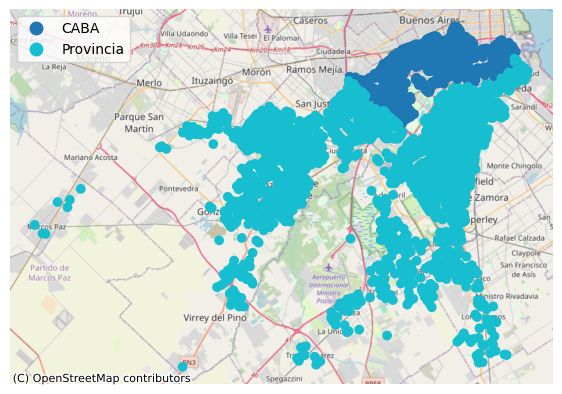

In [ ]:
# Arma el Mapa
Centroide_Radios_1_3857 = Centroide_Radios_1.to_crs(epsg=3857)
fig, ax1 = plt.subplots(figsize = (7,7))
Centroide_Radios_1_3857.plot(column='Provincia',
           ax=ax1,
           legend=True)
cx.add_basemap(ax1, source=cx.providers.OpenStreetMap.Mapnik)
ax1.set_axis_off()
plt.show()
plt.close()

Otro agrupamiento: Seleccionamos los Radios Censales de CABA y comparamos entre los que están dentro de la CMR y los que están en otras cuenca.

In [ ]:
Centroide_Radios_CABA = Centroide_Radios[Centroide_Radios['fna'].str.startswith('Comuna')].copy()
Centroide_Radios_CABA['CMR'] = np.where(Centroide_Radios_CABA['CUENCA'] == 'BAJA', 'CMR', 'OTRA')
Centroide_Radios_CABA = pd.merge(Centroide_Radios_CABA,NBI,on='link')

In [ ]:
Centroide_Radios_CABA.CUENCA.unique()

array([None, 'BAJA'], dtype=object)

## Histograma

Agrupar elementos mediante alguna variable nos permite compararlos. Por ejemplo, podemos crear un histograma que muestra la distribución de la variable *personas_con_nbi_porc* (porcentaje de personas con necesidades básicas insatisfechas), para los habitatnes de la cuenca que esta en CABA y los que estan en Provincia.

El argumento **hue** permite distinguir y colorear las diferentes agrupaciones en el histograma, lo que facilita ver cómo se distribuye esta variable en cada caso.

<Axes: xlabel='personas_con_nbi_porc', ylabel='Count'>

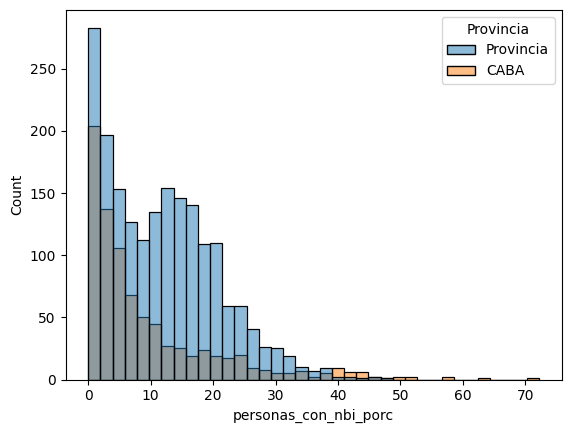

In [ ]:
sns.histplot(data=Centroide_Radios_1, x="personas_con_nbi_porc", hue="Provincia")
# sns.histplot(data=Centroide_Radios_CABA, x="personas_con_nbi_porc", hue="CMR")

Podemos repeteri en analisis pero ahora distinguiendo entre los habitatnes de la Cuenca Baja y de la Cuenca Media

<Axes: xlabel='personas_con_nbi_porc', ylabel='Count'>

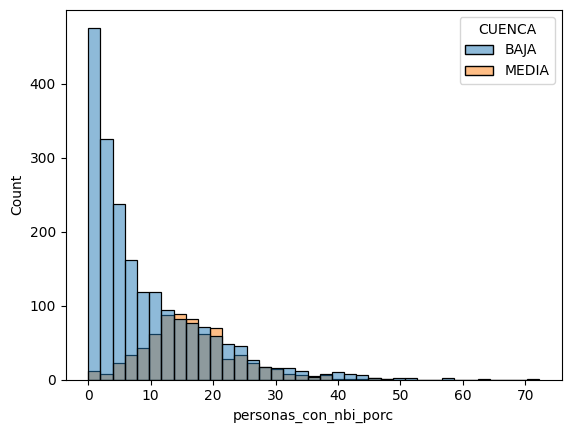

In [ ]:
sns.histplot(data=Centroide_Radios_1, x="personas_con_nbi_porc", hue="CUENCA")

## Box Plot

Con el gráfico boxplot (diagrama de caja) podemos visualizar y comparar la distribución de la variable en función de la ubicación en la cuenca.

<Axes: xlabel='CUENCA', ylabel='personas_con_nbi_porc'>

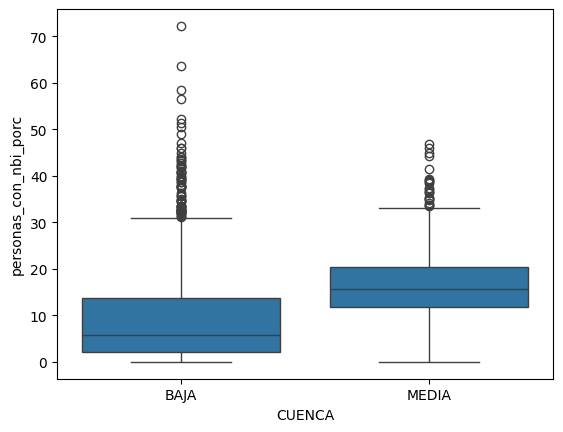

In [ ]:
sns.boxplot(data=Centroide_Radios_1, x="CUENCA", y="personas_con_nbi_porc")
# sns.boxplot(data=Centroide_Radios_CABA, x="CMR", y="personas_con_nbi_porc")

### Recurrencia de inundación
Ahora vamos a usar el raster la **recurrencia de inundación**.

Nos brinda informacion de las zonas afectads para con recurrencias de: 2, 5, 10 ,25, 50 ,100, 200, 500 años.


In [ ]:
Centroide_Radios_1.Manchas_X_TR.unique()

array([  0.,  50.,  nan, 100., 500., 200.,   5.,   2.,  25.,  10.])

Se asigna valor = 0 a los elementos donde no hay afectación

In [ ]:
Centroide_Radios_1['Manchas_X_TR'] = Centroide_Radios_1['Manchas_X_TR'].fillna(0)

Crea una nueva columna llamada '*afectado*'.

Asigna valores a esta columna basándose en la columna 'Manchas_X_TR'.
*   Si la columna 'Manchas_X_TR' no es cero, se asigna 'SI' a la columna 'afectado'.
*   Si la columna 'Manchas_X_TR' es cero, se asigna 'NO' a la columna 'afectado'.

In [ ]:
Centroide_Radios_1['afectado'] = np.where(Centroide_Radios_1['Manchas_X_TR']==0, 'NO', 'SI')

<Axes: xlabel='afectado', ylabel='personas_con_nbi_porc'>

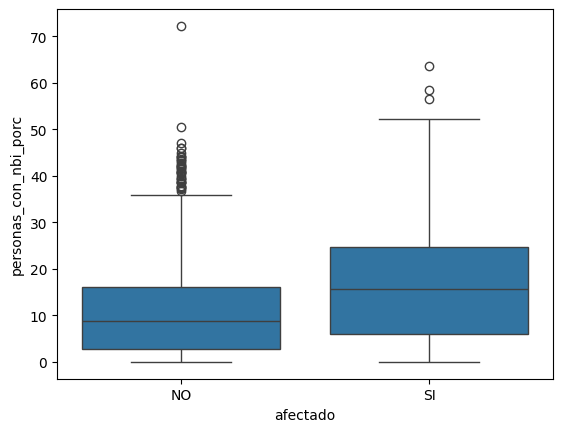

In [ ]:
sns.boxplot(data=Centroide_Radios_1, x="afectado", y="personas_con_nbi_porc")

La volvemos a generar pero ahora nos cetramos en las Radios Censales que se inundan con mayor frecuencia.

In [ ]:
Centroide_Radios_1['afectado_v2'] = np.where(
    Centroide_Radios_1['Manchas_X_TR'] == 0, 'NO',
    np.where(Centroide_Radios_1['Manchas_X_TR'] > 20, 'NO', 'SI'))

<Axes: xlabel='afectado_v2', ylabel='personas_con_nbi_porc'>

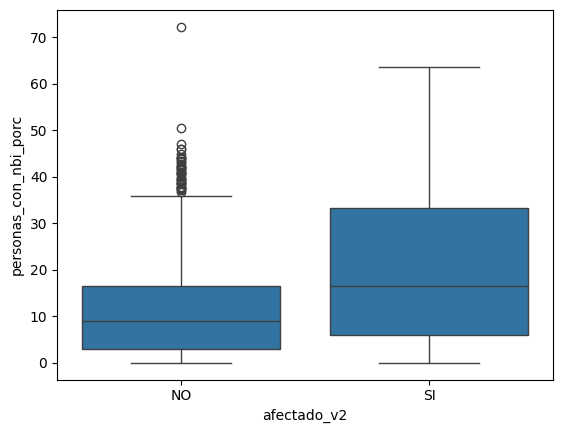

In [ ]:
sns.boxplot(data=Centroide_Radios_1, x="afectado_v2", y="personas_con_nbi_porc")

## Correlación

Para este ejemplo vamos a agregar los datos de Hacinamiento.

La variable "más_de_3_p" representa el porcentaje de hogares en los que viven más de 3 personas por cuarto o habitación.

El hacinamiento se utiliza como un indicador de las condiciones de vida en los hogares, y un mayor valor en esta variable sugiere condiciones de hacinamiento severo, donde la cantidad de personas que ocupan un espacio reducido es alta.

In [ ]:
Hacinamiento = gpd.read_file(root_path+'Censo2010/hacinamiento_4326.gpkg')
Hacinamiento = Hacinamiento.rename(columns={'hacinamien':'Hacinamiento',
                                            'mas_de_3.0':'mas_de_3_p',
                                            'hasta_0.50':'hasta_050_p',
                                            'de_0.51_a_':'de_051_a_099p',
                                            'de_1.00_a_':'de_100_a_149p',
                                            'de_1.50_a_':'de_150_a_199p',
                                            'de_2.00_a_':'de_200_a_300p'})
del Hacinamiento['geometry']

Se combinan los datos de hacinamiento con otro dataframe que ya contiene información utilizando la columna link como clave común.

In [ ]:
Centroide_Radios_2 = pd.merge(Centroide_Radios_1,Hacinamiento,on='link')

In [ ]:
Centroide_Radios_2.columns

Index(['link', 'Area_ha', 'NOMBRE', 'CUENCA', 'fna', 'gna', 'Manchas_X_TR',
       'Dist_CentrosSalud', 'geometry', 'CantParadas', 'varon', 'mujer',
       'personas', 'hogares', 'viv_part', 'viv_part_hab', 'densidad',
       'personas_con_nbi', 'personas_con_nbi_porc', 'total_pob',
       'hogares_con_nbi', 'hogares_con_nbi_porc', 'total_hog', 'Provincia',
       'afectado', 'afectado_v2', 'Hacinamiento', 'mas_de_3_p', 'total_hoga',
       'hasta_050_p', 'de_051_a_099p', 'de_100_a_149p', 'de_150_a_199p',
       'de_200_a_300p'],
      dtype='object')

Se genera un gráfico de dispersión usando seaborn para visualizar la relación entre el porcentaje de personas con necesidades básicas insatisfechas (NBI) y el porcentaje de hogares con más de 3 personas por habitación.

<Axes: xlabel='personas_con_nbi_porc', ylabel='mas_de_3_p'>

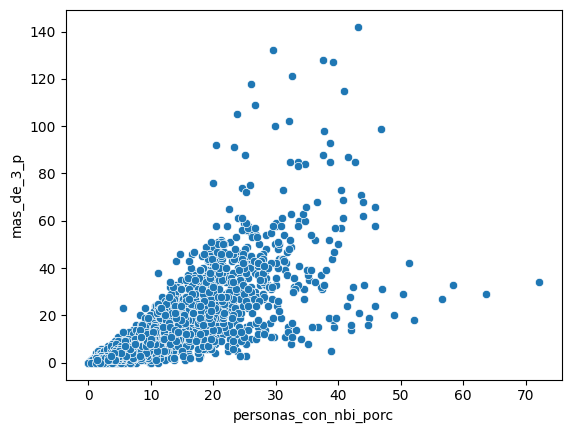

In [ ]:
sns.scatterplot(data=Centroide_Radios_2, x="personas_con_nbi_porc", y="mas_de_3_p")

## Mapa Temático

Si queremos armar un mapa temático tendríamos que recuperar la geometría original de los Radios Censales (no la de los Centroides). Para esto volvamos a cargar una de las capas y tomemos la Geometría.

In [ ]:
DatosBasicos = gpd.read_file(root_path+'Censo2010/DatosBasicos_4326.gpkg')
# Selecciona solo dos columnas del archivo:
#   link: es el identificador común para hacer el merge,
#   geometry: que contiene la geometría de los polígonos de los radios censales
DatosBasicos = DatosBasicos[['link','geometry']]

# Cambia el sistema de referencia de coordenadas (CRS)
DatosBasicos = DatosBasicos.to_crs(epsg=3857)

# Se hace una copia del dataframe para evitar modificaciones sobre los datos originales.
Centroide_Radios_Mapa = Centroide_Radios_1.copy()

# Elimina la columna geometry del dataframe Centroide_Radios_Mapa,
# ya que en el siguiente paso vas a agregar la geometría de la capa DatosBasicos que acabas de leer.
del Centroide_Radios_Mapa['geometry']

# Realiza una unión entre el dataframe Centroide_Radios_Mapa y DatosBasicos usando la columna link como clave común.
# Esto añade la columna geometry del archivo DatosBasicos a Centroide_Radios_Mapa.
Centroide_Radios_Mapa = pd.merge(Centroide_Radios_Mapa,DatosBasicos,on='link')

# Se asegura de que la columna geometry en Centroide_Radios_Mapa sea tratada como
# la geometría activa para la visualización y análisis espacial en geopandas.
Centroide_Radios_Mapa = Centroide_Radios_Mapa.set_geometry(Centroide_Radios_Mapa['geometry'])

# Filra solo aquellos radios censales que están dentro de la Ciudad Autónoma de Buenos Aires.
Centroide_Radios_Mapa = Centroide_Radios_Mapa[Centroide_Radios_Mapa["Provincia"] == 'CABA']

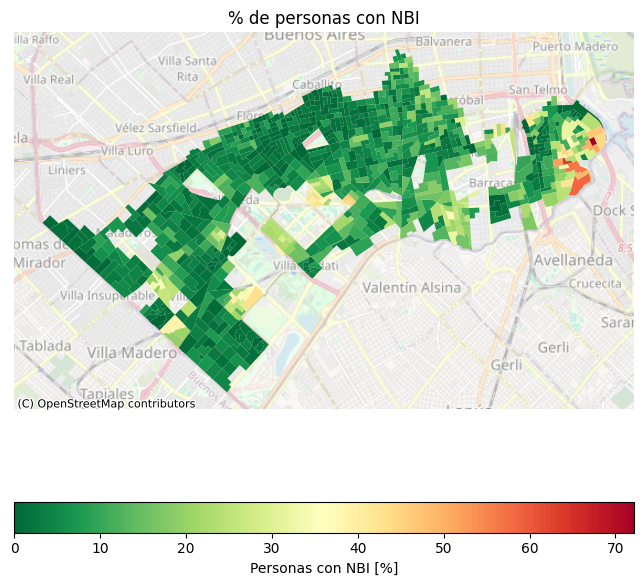

In [ ]:
# Genera el Mapa
fig, ax1 = plt.subplots(figsize = (8,8))

plt.title('% de personas con NBI')
Centroide_Radios_Mapa.plot(column='personas_con_nbi_porc',
           ax=ax1,
           legend=True,
           cmap='RdYlGn_r',
           legend_kwds={'label': "Personas con NBI [%]",
                        'orientation': "horizontal"})
cx.add_basemap(ax1, source=cx.providers.OpenStreetMap.Mapnik,alpha=0.5)        # Capa Base
ax1.set_axis_off()
plt.show()
plt.close()

# Otros Datos

Hogares con agua de red

In [ ]:
AguaDeRed = gpd.read_file(root_path+'Censo2010/hogares_con_agua_red_4326.gpkg')
AguaDeRed = AguaDeRed.rename(columns={'red_public':'red_publica',
                                      'red_publ_1':'red_publica_porcentaje',
                                      'perforacio':'perforacion_con_bomba_a_motor',
                                      'perforac_1':'perforacion_con_bomba_manual',
                                      'transporte':'transporte_por_cisterna',
                                      'agua_de_ll':'agua_de_lluvia_rio_canal_otros'})
del AguaDeRed['geometry']

Hogares con gas de red


In [ ]:
ConGas = gpd.read_file(root_path+'Censo2010/hogares_con_gas_de_red_4326.gpkg')
ConGas = ConGas.rename(columns={'gas_de_por':'gas_de_red_p',
                                'gas_en_gar':'gas_en_garrafa',
                                'electricid':'electricidad',
                                'leña_o_ca':'leña_o_carbon'})
del ConGas['geometry']

Hogares con desagüe cloacal

In [ ]:
ConsDesCloacal = gpd.read_file(root_path+'Censo2010/hogares_con_desague_cloacal_4326.gpkg')
ConsDesCloacal = ConsDesCloacal.rename(columns={'red_cloaca':'red_cloacal',
                                                'red_cloa_1':'red_cloacal_porcentaje',
                                                'a_camara_s':'a_camara_septica_y_pozo_ciego',
                                                'solo_pozo_':'solo_pozo_ciego',
                                                'a_hoyo_exc':'a_hoyo_excavacion_otros'})
del ConsDesCloacal['geometry']

Hogares por calidad de los materiales de la vivienda - INMAT


In [ ]:
inmat = gpd.read_file(root_path+'Censo2010/inmat_4326.gpkg')
inmat = inmat.rename(columns={'calidad_1_':'calidad_1_p',
                              'calidad_2_':'calidad_2_p',
                              'calidad_3_':'calidad_3_p',
                              'calidad_4_':'calidad_4_p',
                              'total':'total_inmat'})
del inmat['geometry']

Hogares en viviendas según calidad de conexión a servicios básica - INLASERV


In [ ]:
incalserv = gpd.read_file(root_path+'Censo2010/incalserv_4326.gpkg')
incalserv = incalserv.rename(columns={'satisfac_1':'satisfactoria_p',
                                      'basica_por':'basica_p',
                                      'insufici_1':'insuficiente_p',
                                      'total':'total_incalserv'})
del incalserv['geometry']

Hogares en situación de hacinamiento crítico

In [ ]:
Hacinamiento = gpd.read_file(root_path+'Censo2010/hacinamiento_4326.gpkg')
Hacinamiento = Hacinamiento.rename(columns={'hacinamien':'Hacinamiento',
                                            'mas_de_3.0':'mas_de_3_p',
                                            'hasta_0.50':'hasta_050_p',
                                            'de_0.51_a_':'de_051_a_099p',
                                            'de_1.00_a_':'de_100_a_149p',
                                            'de_1.50_a_':'de_150_a_199p',
                                            'de_2.00_a_':'de_200_a_300p'})
del Hacinamiento['geometry']

Calidad constructiva de la vivienda - INCALCONS

In [ ]:
incalcons = gpd.read_file(root_path+'Censo2010/incalcons_4326.gpkg')
incalcons = incalcons.rename(columns={'satisfacto':'satisfactoria',
                                      'satisfac_1':'satisfactoria_p',
                                      'basico_por':'basico_p',
                                      'insuficien':'insuficiente',
                                      'insufici_1':'insuficiente_p',
                                      'total':'total_incalcons'})
del incalcons['geometry']

In [ ]:
Centroide_Radios = pd.merge(Centroide_Radios,NBI,on='link')
Centroide_Radios = pd.merge(Centroide_Radios,inmat,on='link')
Centroide_Radios = pd.merge(Centroide_Radios,incalserv,on='link')
Centroide_Radios = pd.merge(Centroide_Radios,incalcons,on='link')